# Cleaning notebook for EAGLE-I dataset

Original dataset can be found at https://www.osti.gov/dataexplorer/biblio/dataset/1975202.
It has data for 2014-2022, separated by year (one csv file per year. Most of these are ~1GB in size.) 

## Dropping redundant fields

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df = pd.read_csv("eaglei_outages/eaglei_outages_2014.csv",parse_dates=["run_start_time"])

In [21]:
df.head()

,fips_code,county,state,sum,run_start_time
0,1037,Coosa,Alabama,12,2014-11-01 04:00:00
1,1051,Elmore,Alabama,7,2014-11-01 04:00:00
2,1109,Pike,Alabama,1,2014-11-01 04:00:00
3,1121,Talladega,Alabama,31,2014-11-01 04:00:00
4,4017,Navajo,Arizona,1,2014-11-01 04:00:00


In [6]:
df.loc[df.fips_code==12073].county.describe()

count     19401
unique        1
top        Leon
freq      19401
Name: county, dtype: object

FIPS codes correspond to counties (see https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt), so we may as well keep only the FIPS code so the data is more compact (saves about 1.2GB), and maintain separate look-up dictionaries for county / state by FIPS code. Note the state FIPS code is the first two digits of the county FIPS code.

In [22]:
fips_county = {}
for fips in df.groupby("fips_code"): 
    fips_county[fips[0]] = fips[1].iloc[0].county

In [5]:
state_fips = {}
for state in df.groupby("state"):
    state_fips[state[0]] = int((state[1].iloc[0].fips_code)/1000)

In [23]:
df.drop(["county","state"],axis=1,inplace=True)
#df["state"]=(df["fips_code"]/1000).apply(int)

In [24]:
df.head()

,fips_code,sum,run_start_time
0,1037,12,2014-11-01 04:00:00
1,1051,7,2014-11-01 04:00:00
2,1109,1,2014-11-01 04:00:00
3,1121,31,2014-11-01 04:00:00
4,4017,1,2014-11-01 04:00:00


This was then saved using `df.to_csv("eaglei_outages_YYYY_cpt.csv")`

In [25]:
df.to_csv("eaglei_outages_2014_cpt.csv",index=False)

We also save the FIPS lookup tables

In [26]:
pd.DataFrame({"FIPS":fips_county.keys(),"county":fips_county.values()}).to_csv("fips_county_2014.csv",index=False)

In [ ]:
# the state_fips table only needs to be saved once --- all of the states show up in the 2022 data.

We then merge the FIPS lookup tables to remove redundancy

In [145]:
df = pd.read_csv("fips_county_2014.csv", index_col=None, header=0)

for yr in range(2015,2023):
    df2 =  pd.read_csv("fips_county_"+str(yr)+".csv", index_col=None, header=0)
    df3=df.merge(df2, on="FIPS", how="outer")
    df=pd.concat([df3.loc[df3.isna().county_x].drop(["county_x"],axis=1).rename({"county_y":"county"},axis=1),
               df3.loc[~(df3.isna().county_x)].drop(["county_y"],axis=1).rename({"county_x":"county"},axis=1)])
    #li.append(df)

#frame = pd.concat(li, axis=0, ignore_index=True)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3087 entries, 0 to 3086
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   FIPS    3087 non-null   int64 
 1   county  3087 non-null   object
dtypes: int64(1), object(1)
memory usage: 72.4+ KB


In [147]:
df.to_csv("fips_county.csv",index=False)

## Generating tables of outage events

We next create a table where each row corresponds to a power outage event in a county. We group together rows with consecutive timestamps and the same fips_code. 

For # affected customers we use the number indicated at the start of the event. (We could maybe use the maximum number seen across the time period? This would take a little bit more work.)
We also estimate the duration as 15 min * (# consecutive rows grouped + 1); this is recorded in minutes.

In [2]:
import datetime

In [23]:
df = pd.read_csv("eaglei_outages/eaglei_outages_2014_cpt.csv", parse_dates=["run_start_time"])

Next three fields try out the code for a single county before running it on all counties

In [48]:
code = 12073 # Leon County, FL
#code = 55025 # Dane County, WI 
df_county = df.loc[df.fips_code==code]
outages_county = pd.DataFrame({"fips_code":[], 'affected':[], 'start':[], 'end':[], 'duration':[]})

In [49]:
fifteen = datetime.timedelta(minutes=15)
timediff = df_county.run_start_time.shift(-1) 
continues = (timediff - df_county.run_start_time) == fifteen
isEnd = ~continues 
isStart = isEnd.shift(1, fill_value=True)
outage_county = df_county[isStart].rename({"sum":"affected", "run_start_time":"start"},axis=1).reset_index()
outage_county["end"] = df_county[isEnd].reset_index().run_start_time
outage_county["duration"] = (outage_county["end"] - outage_county["start"]).apply(lambda x: x.total_seconds()/60+15).apply(int)
#isEnd.loc[isEnd].keys()[:5], isStart.loc[isStart].keys()[:5]

In [104]:
pd.concat([outage_county,oc2]).info()
len(oc2), len(outage_county)

<class 'pandas.core.frame.DataFrame'>
Index: 2279 entries, 0 to 1617
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   index      2279 non-null   int64          
 1   fips_code  2279 non-null   int64          
 2   affected   2096 non-null   float64        
 3   start      2279 non-null   datetime64[ns] 
 4   end        2279 non-null   datetime64[ns] 
 5   duration   2279 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), timedelta64[ns](1)
memory usage: 124.6 KB


In [50]:
outage_county.head()

,index,fips_code,affected,start,end,duration
0,3237,12073,1.0,2022-01-01 01:30:00,2022-01-01 01:30:00,15
1,6146,12073,1.0,2022-01-01 03:00:00,2022-01-01 03:00:00,15
2,11373,12073,1.0,2022-01-01 05:45:00,2022-01-01 07:45:00,135
3,25868,12073,1.0,2022-01-01 12:30:00,2022-01-01 14:15:00,120
4,31797,12073,7.0,2022-01-01 14:45:00,2022-01-01 17:00:00,150


We should be good to go!

In [24]:
out_by_fips = df.groupby("fips_code")
fifteen = datetime.timedelta(minutes=15)

li = []
for fips, df_county in out_by_fips:
    timediff = df_county.run_start_time.shift(-1) 
    continues = (timediff - df_county.run_start_time) == fifteen
    isEnd = ~continues 
    isStart = isEnd.shift(1, fill_value=True)
    outage_county = df_county[isStart].rename({"sum":"affected", "run_start_time":"start"},axis=1).reset_index()
    outage_county["end"] = df_county[isEnd].reset_index().run_start_time
    outage_county["duration"] = (outage_county["end"] - outage_county["start"]).apply(lambda x: x.total_seconds()/60).apply(int)
    li.append(outage_county)

outages = pd.concat(li).dropna()

In [ ]:
# older code, not parallelized, not efficient; do not use.
out_by_fips = df.groupby("fips_code")
outages = pd.DataFrame({"fips_code":[], 'affected':[], 'start':[], 'end':[], 'duration':[]})
for fips, df_county in out_by_fips:
    start = 0
    for i in range(len(df_county)):
        if i == len(df_county)-1 or (df_county.iloc[i+1].run_start_time 
                                - df_county.iloc[i].run_start_time) > datetime.timedelta(minutes=15):
            outages.loc[len(outages.index)] = [fips, df_county.iloc[range(start,i+1)]["sum"].max(), 
                                                     df_county.iloc[start].run_start_time, 
                                                     df_county.iloc[i].run_start_time,(i-start+1)*15]
            if i < len(df_county) - 1: start = i+1

In [25]:
outages.drop(["index"],axis=1).dropna().to_csv("outages_2014.csv",index=False)

## Removing apparent noise?

In [53]:
outages = pd.read_csv("outages_2022.csv",parse_dates=["start","end"])

In [54]:
outages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364783 entries, 0 to 1364782
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   fips_code  1364783 non-null  int64         
 1   affected   1364783 non-null  float64       
 2   start      1364783 non-null  datetime64[ns]
 3   end        1364783 non-null  datetime64[ns]
 4   duration   1364783 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 52.1 MB


In [55]:
soutage = outages.sample(12000)

In [56]:
soutage.head()

,fips_code,affected,start,end,duration
1309922,54033,4.0,2022-01-08 10:00:00,2022-01-08 12:45:00,165
328902,17195,11.0,2022-08-22 13:30:00,2022-08-22 14:45:00,75
1252824,51095,1.0,2022-04-21 16:00:00,2022-04-22 15:45:00,1425
404174,20009,1.0,2022-07-13 23:45:00,2022-07-14 04:45:00,300
1312374,54041,173.0,2022-09-01 01:30:00,2022-09-01 06:45:00,315


<Axes: >

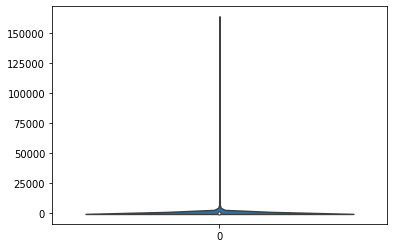

In [57]:
sns.violinplot(soutage.duration.values)

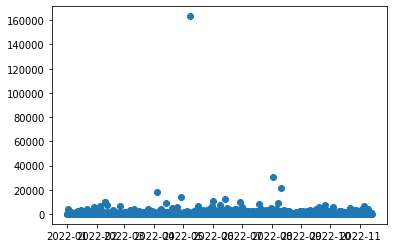

In [58]:
plt.scatter(soutage.start, soutage.duration)
# Yeah something happened in October 2015 ... which hurricane was that?

Question: should we delete events where the # affected customers is very small (and/or the duration is very short)?

<Axes: >

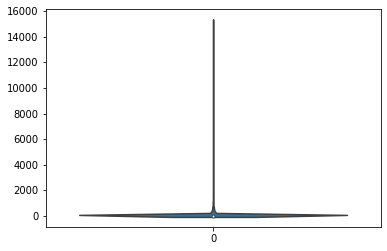

In [59]:
sns.violinplot(soutage.affected.values)

In [60]:
soutage.drop(soutage.loc[(soutage.affected==1) | (soutage.duration<=30)].index,inplace=True)

In [61]:
soutage

,fips_code,affected,start,end,duration
1309922,54033,4.0,2022-01-08 10:00:00,2022-01-08 12:45:00,165
328902,17195,11.0,2022-08-22 13:30:00,2022-08-22 14:45:00,75
1312374,54041,173.0,2022-09-01 01:30:00,2022-09-01 06:45:00,315
474773,21207,37.0,2022-02-22 04:15:00,2022-02-22 06:45:00,150
568695,26029,2.0,2022-04-07 17:30:00,2022-04-07 19:30:00,120
...,...,...,...,...,...
280873,16035,4.0,2022-09-01 16:30:00,2022-09-01 20:30:00,240
751212,35001,24.0,2022-05-26 05:30:00,2022-05-26 09:00:00,210
881817,39069,4.0,2022-05-31 16:30:00,2022-05-31 18:00:00,90
847496,37167,2.0,2022-03-19 17:45:00,2022-03-19 18:30:00,45


<Axes: >

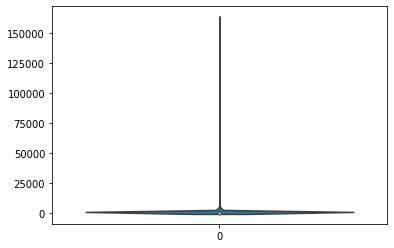

In [62]:
sns.violinplot(soutage.duration.values)

<Axes: >

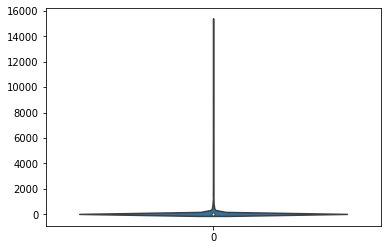

In [63]:
sns.violinplot(soutage.affected.values)